In [25]:
import numpy as np
import h5py
import scipy as sp # For finding the centroid
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.constants as cons
import scipy
import math
import matplotlib.gridspec as gridspec
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from openpmd_viewer import ParticleTracker
pi = cons.pi
clight = cons.speed_of_light
epsilon_0 = cons.epsilon_0
me = cons.electron_mass
qe = cons.elementary_charge

########################################################################
def add_colorbar(im, width=None, pad=None, **kwargs):
    l, b, w, h = im.axes.get_position().bounds       # get boundaries
    width = width or 0.05 * w                         # get width of the colorbar
    pad = pad or width                               # get pad between im and cbar
    fig = im.axes.figure                             # get figure of image
    cax = fig.add_axes([l + w + pad, b, width, h])   # define cbar Axes
    return fig.colorbar(im, cax=cax, **kwargs)       # draw cbar
########################################################################

In [26]:
lam = 0.8e-6       # wavelength m 
nc = 1.74e27       # Critical density m^-3
a0 = 2.5             # normalized vector potential
ne_0 = 0.0065*nc       # density in terms if critical ~3.5e18 cm^3
ne_1 = 0.0026*nc       # density in terms if critical ~3.5e18 cm^3
wp = ((ne_0*qe**2) / (me*epsilon_0))**(1/2)
lam_p = (2*pi*clight)/wp
tau = (lam_p/2)/clight

# Load the output files for the field located in diag1 and the particles located in diag2

In [27]:
path_fields ='/Users/victorflores/warpx_env/WarpX/Wake_Field_2D/diags/diag1'
path_particles ='/Users/victorflores/warpx_env/WarpX/Wake_Field_2D/diags/diag2'

# Holds field data 
data_f= OpenPMDTimeSeries("{}".format(path_fields),backend="h5py")

# Holds particle data 
data_p= OpenPMDTimeSeries("{}".format(path_particles),backend="h5py")

### Check how many data files you got 

In [28]:
len(data_f.iterations)

11

# We are going to load:

# $$E_y$$
# $$E_x$$
# $$E_z$$
# $$n_e$$

# Can you tell me what these represent and how we normalize them ?

In [29]:
j = 10
t=data_f.t[j]
Ey, Ey_info = data_f.get_field(t=data_f.t[j], field='E',coord="y", plot=False)
Ez, Ez_info = data_f.get_field(t=data_f.t[j], field='E',coord="z", plot=False)
Ex, Ex_info = data_f.get_field(t=data_f.t[j], field='E',coord="x", plot=False)
rho_ele, ele_info = data_f.get_field(t=data_f.t[j], field='rho_electrons', plot=False)
Ey_slice, Ey_info_slice = data_f.get_field(t=data_f.t[j], field='E',coord="y", plot=False, slice_across="x",slice_relative_position= 0)
Ez_slice, Ez_info_slice = data_f.get_field(t=data_f.t[j], field='E',coord="z", plot=False, slice_across="x",slice_relative_position= 0)
rho_ele_slice, ele_info_slice = data_f.get_field(t=data_f.t[j], field='rho_electrons', plot=False, slice_across="x",slice_relative_position= 0)

ne_nc = (rho_ele / -qe)/nc
ne_nc_slice = (rho_ele_slice / -qe)/nc
norm_field = 4e12
Ey_a0_slice = Ey_slice / norm_field
Ey_a0 = Ey / norm_field
Z = Ey_info.z
X = Ey_info.x

# Plot the field quantities

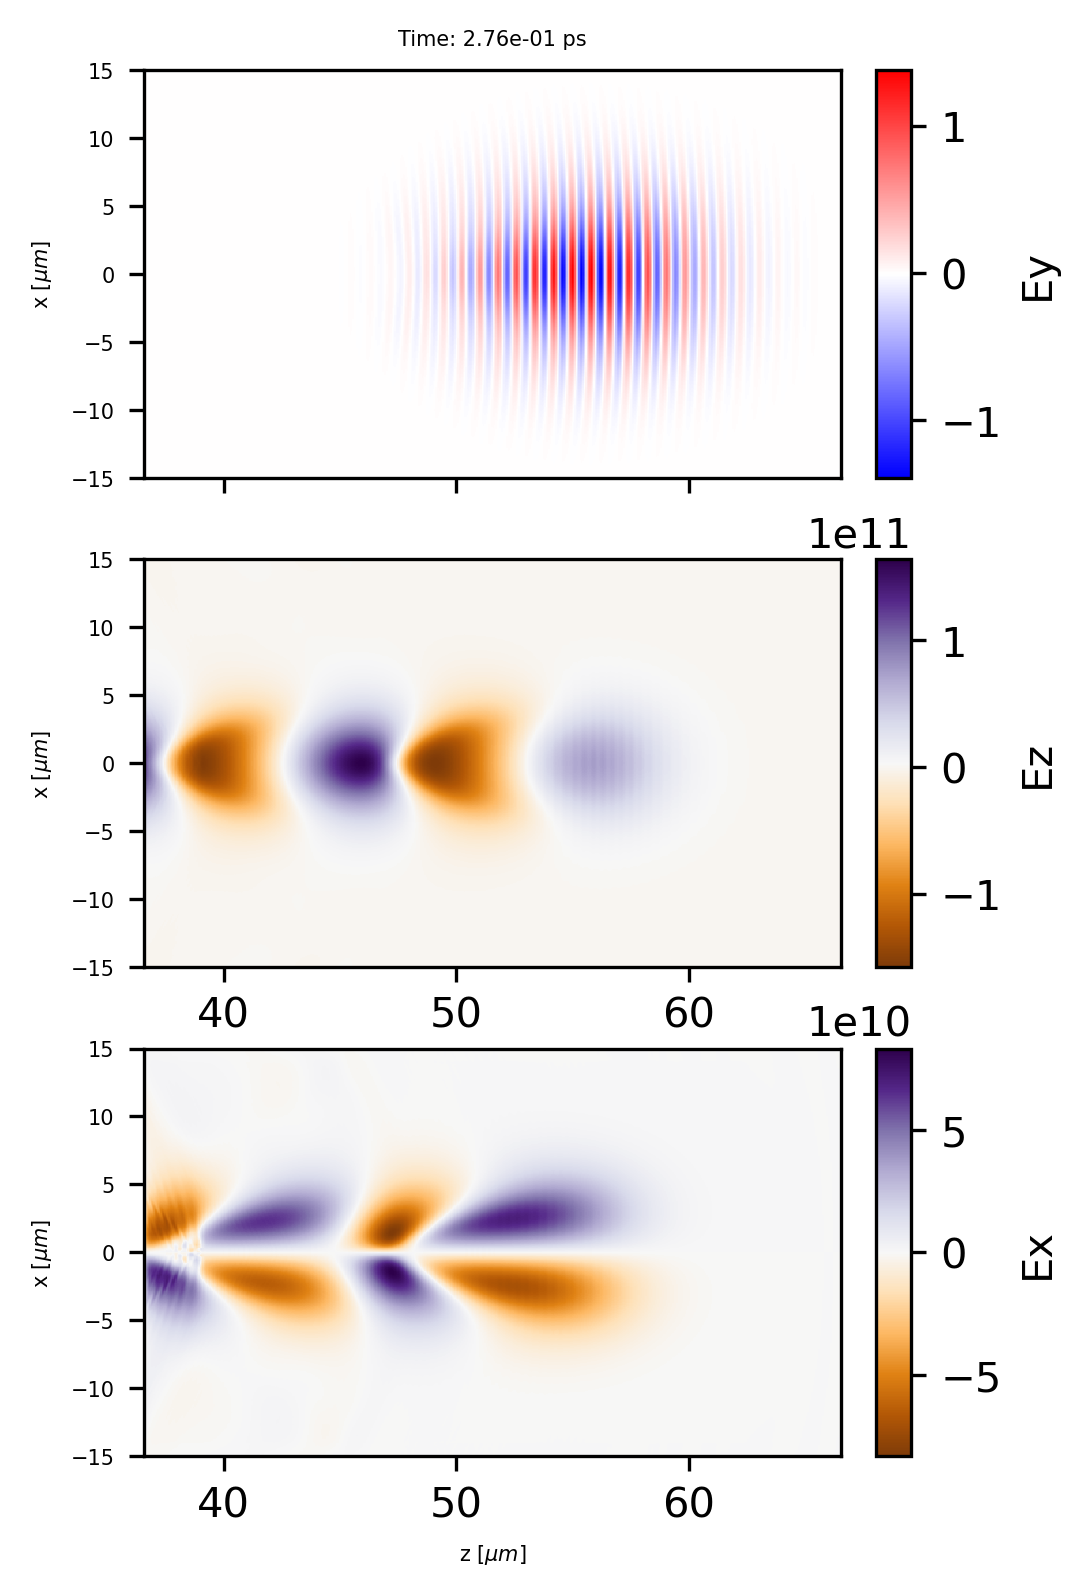

In [30]:
#####################################
fig_width = 3 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, ax = plt.subplots(3,1,figsize=(fig_width, 3*fig_height), dpi=300)

Ey = ax[0].pcolormesh(Z *10**6, X*10**6, Ey_a0.T, cmap='bwr')
cb1 = add_colorbar(Ey)
cb1.set_label(r'Ey')
ax[0].set_xticklabels([])
ax[0].tick_params('y',labelsize=5)
ax[0].set_ylabel(r'x [$\mu m$]', fontsize = 5)
ax[0].set_title('Time: {:.2e} ps'.format(t*10**12),fontsize=5)

Ez = ax[1].pcolormesh(Z *10**6, X*10**6, Ez.T, cmap='PuOr')
cb1 = add_colorbar(Ez)
cb1.set_label(r'Ez')
ax[1].tick_params('y',labelsize=5)
ax[1].set_ylabel(r'x [$\mu m$]', fontsize = 5)

Ex = ax[2].pcolormesh(Z *10**6, X*10**6, Ex.T, cmap='PuOr')
cb1 = add_colorbar(Ex)
cb1.set_label(r'Ex')
ax[2].tick_params('y',labelsize=5)
ax[2].set_ylabel(r'x [$\mu m$]', fontsize = 5)
ax[2].set_xlabel(r'z [$\mu m$]', fontsize = 5)

plt.show()

# Plot the density

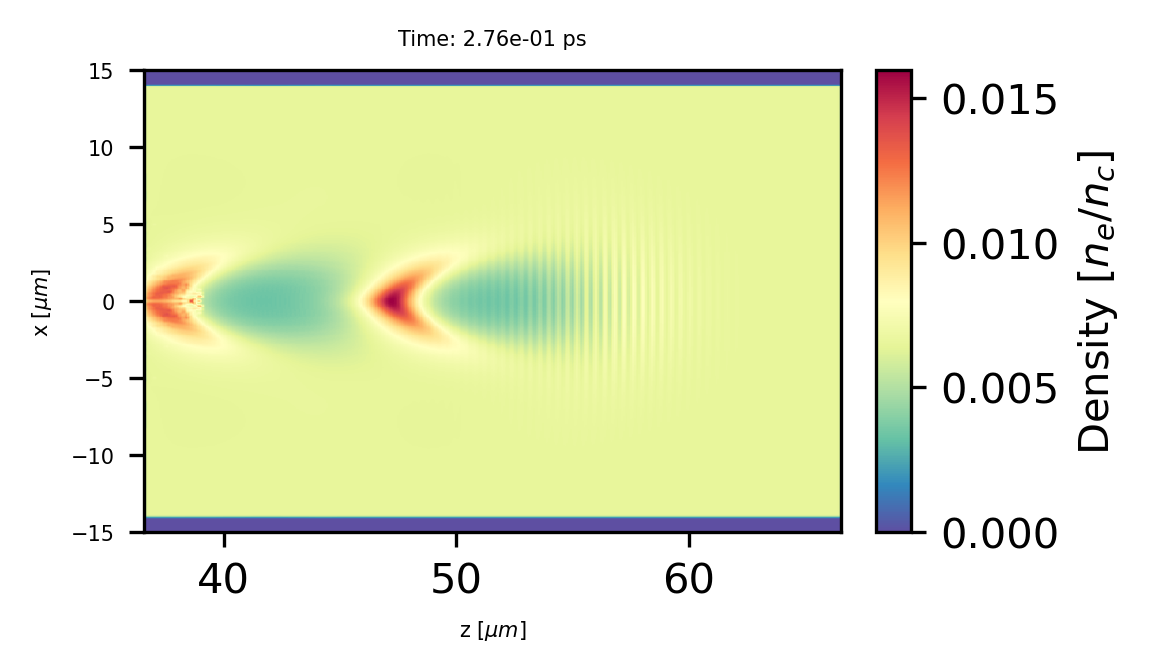

In [31]:
#####################################
fig_width = 3 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, ax = plt.subplots(1,1,figsize=(fig_width, fig_height), dpi=300)

dens_map = ax.pcolormesh(Z *10**6, X*10**6, ne_nc.T, cmap='Spectral_r')
cb1 = add_colorbar(dens_map)
cb1.set_label(r'Density [$n_e / n_c$]')
ax.tick_params('y',labelsize=5)
ax.set_ylabel(r'x [$\mu m$]', fontsize = 5)
ax.set_title('Time: {:.2e} ps'.format(t*10**12),fontsize=5)
ax.set_xlabel(r'z [$\mu m$]', fontsize = 5)
plt.show()

# Plot a 1D outline sliced from the center x = 0. What do you expect to see?

Text(0.5, 0, 'z [$\\mu m$]')

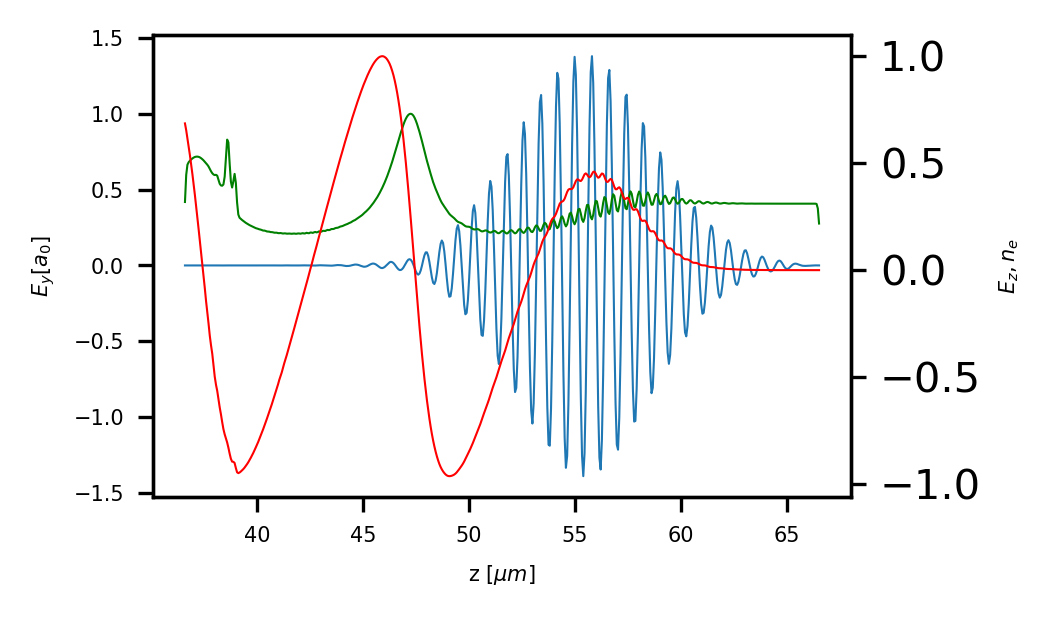

In [32]:
fig_width = 3 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, ax = plt.subplots(1,1,figsize=(fig_width, fig_height), dpi=300)

ax.plot(Z*10**6 , Ey_a0_slice, linewidth = 0.5)
ax2 = ax.twinx()
ax2.plot(Z*10**6 , Ez_slice/np.max(Ez_slice), linewidth = 0.5,color='red')
ax.plot(Z*10**6 , ne_nc_slice / np.max(ne_nc_slice), linewidth = 0.5,color='green')
ax.tick_params('x',labelsize=5)
ax.tick_params('y',labelsize=5)
ax.set_ylabel(r'$E_y [a_0]$', fontsize = 5)
ax2.set_ylabel(r'$E_z, n_e$', fontsize = 5)
ax.set_xlabel(r'z [$\mu m$]', fontsize = 5)

# Get particle information to look at the phase space (z,uz)

## Given that Warpx gives the normalized momentum:

# $$u_{z,x} = \gamma \beta_{x,z}$$

## Given that relativistic momentum:

# $$\vec{p} = \gamma m_e \vec{v}$$

## Total energy is:

# $$E = \gamma m_e c^2$$

## The relativistic Energy-Momentum relation is:

# $$E^2 = p^2 c^2 + m^2 c^4$$

# Can you make a plot of the kinetic energy

# $$K = E - m_ec^2 = (\gamma -1) m_e c^2 $$

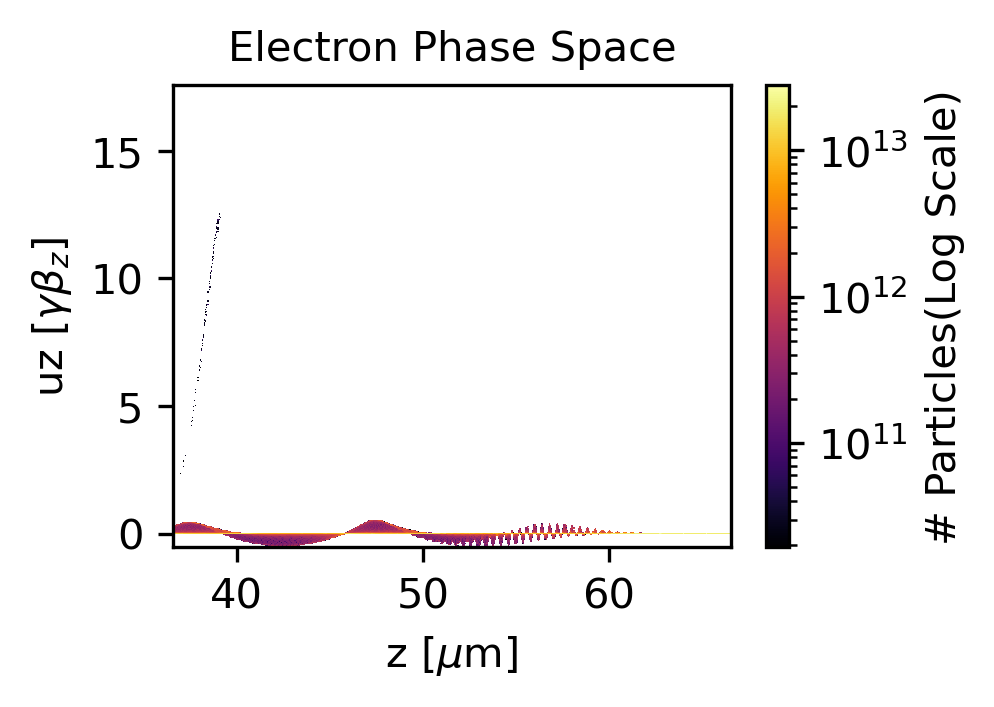

In [33]:
z, uz, w = data_p.get_particle(var_list=['z','uz','w'],t=data_p.t[j], species="electrons", plot=False)
cmap = "inferno"
hist_optsN = {
'norm': LogNorm(),
'cmap': cmap,
'cmin': 1
}
hist_optsbg = {
'norm': LogNorm(),
'cmap': cmap,
'cmin': 1
}



fig_width = 3 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, ax1 = plt.subplots(1,1,figsize=(fig_width, fig_height), dpi=300)
ene_dis = ax1.hist2d(z*10**6,uz,bins = 500,**hist_optsN,zorder=2,weights=w)[3]

ax1.set_title("Electron Phase Space", fontsize=10)
ax1.set_xlabel(r"z [$\mu$m]",fontsize=10)
ax1.set_ylabel(r"uz [$\gamma \beta_z$]",fontsize=10, c ="black")
ax1.tick_params('y',labelsize=10)
ax1.tick_params('x',labelsize=10)
ax1.set_facecolor("none")
min_y = min(ax1.get_ylim())
max_y = max(ax1.get_ylim())
ax1.set_ylim(min_y, max_y+5)
cb1 = fig.colorbar(ene_dis,ax=ax1)
cb1.set_label("# Particles(Log Scale)", fontsize=10)
cb1.ax.tick_params(labelsize=10)